In [2]:
# Whenever you update something to the context (e.g. parameters), run this cell
%reload_kedro

2021-07-03 12:53:07,994 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-07-03 12:53:08,037 - root - INFO - ** Kedro project Foehn fire impact
2021-07-03 12:53:08,038 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-07-03 12:53:08,047 - root - INFO - Registered line magic `run_viz`


In [3]:
# Automatically reloads updates in imported python files
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sci
from utils import *
from plotly import graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from plotly.subplots import make_subplots
#import kedro.framework.context

plt.rcParams["figure.figsize"] = (16,9)
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

In [231]:
# Fire data
df = catalog.load("fire_data_with_foehn_and_control_variables")

2021-07-03 19:15:42,864 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


(0.0, 24.0)

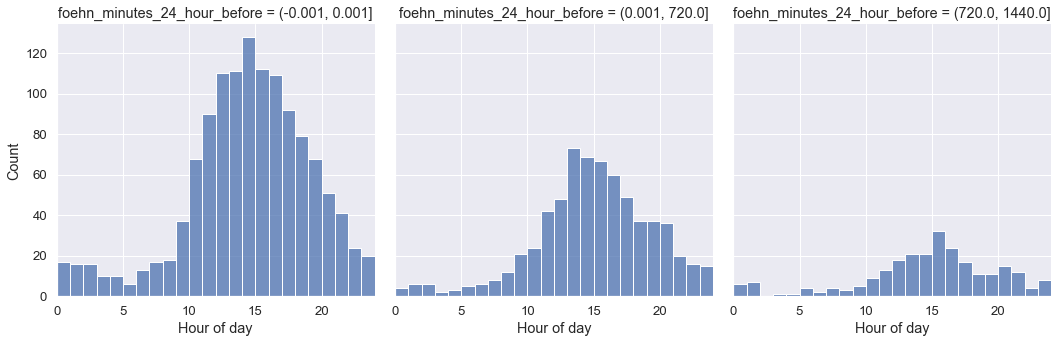

In [10]:
# Investigate hour of day when fire starts, check for shift in distribution for fires with more foehn in beforehand
sns.set(font_scale=1.2)
g = sns.displot(x=df["start_date_min"].dt.hour, 
            col=pd.cut(df["foehn_minutes_24_hour_before"], bins= [-0.001, 0.001, 12*60, 24*60]),
            bins=range(0,24+1),  kind="hist")
for i in range(3):
    g.axes[0,i].set_xlabel("Hour of day")
plt.xlim([0,24])

<AxesSubplot:xlabel='duration_min', ylabel='Probability'>

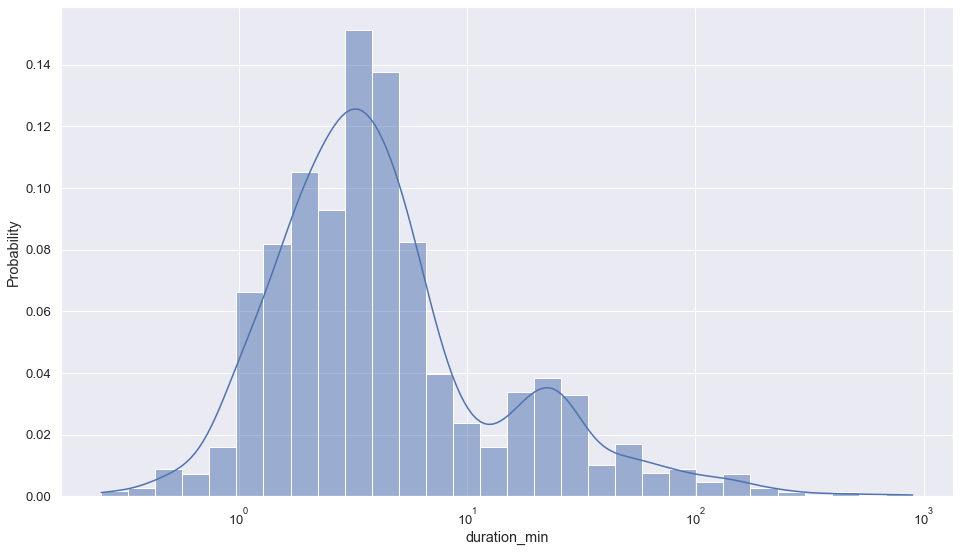

In [303]:
# Fire duration plot
sns.histplot(x=df["duration_min"], log_scale=True, bins=30, stat="probability", kde=True)

# After fire ignition

In [232]:
def filter_data(df, hours, fire_regime, decade, foehn_variant):
    # Filter out all values where foehn presence is unknown
    df = df.loc[df[f"foehn_minutes_during_{hours}_hours_after_start_of_fire"].notnull(), :].reset_index(drop=True)
    
    # Filter by fire regime
    if fire_regime != "All fires":
        df = df.loc[df["fire_regime"]==fire_regime, :].reset_index(drop=True)
    
    # Filter by decade
    if decade == "All":
        pass
    elif decade == ">1990":
        df = df.loc[df["start_date_min"].dt.year > 1990, :].reset_index(drop=True)
    else:
        df = df.loc[df["decade"] == decade, :].reset_index(drop=True)
    
    # Filter by foehn variant 
    if foehn_variant != "Both":
         df = df.loc[df["potential_foehn_species"]==foehn_variant, :].reset_index(drop=True)
    
    return df

In [307]:
@interact
def filter_box_plot(
    comparison=["multiple", "binary"],
    hours=[6,2,12],
    fire_regime=["All fires", "Winter anthropogenic", "Summer anthropogenic"],
    decade=["All", "[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]", ">1990"],
    foehn_variant=["Both", "North foehn", "South foehn"]):
    
    # Filter data
    dff = filter_data(df, hours, fire_regime, decade, foehn_variant)
    
    # Set plot type
    if comparison == "multiple":
        dff["foehn_minutes_binned"] = pd.cut(dff[f"foehn_minutes_during_{hours}_hours_after_start_of_fire"], bins = [-0.001, 0.001] + [hours * 10 * i for i in range(1, 6 + 1)])
        figure_title = f"Burned area vs. foehn minutes after ignition<br>N_fires={len(dff.index)}"
    else:
        dff["foehn_minutes_binned"] = pd.cut(dff[f"foehn_minutes_during_{hours}_hours_after_start_of_fire"], bins = [-0.001, 0.001, 60 * hours])
        pvalue, median_increase_factor = test_binary_bins(dff, hours=hours)
        figure_title = f"Burned area vs. foehn minutes after ignition<br>N_fires={len(dff.index)}<br>p-value (Wilcoxon test): {pvalue}<br>Median increase factor: {median_increase_factor}" 
        
    fig = go.Figure()
    fig.add_trace(
        go.Box(x=dff["foehn_minutes_binned"].astype(str),
               y=dff["total [ha]"],
               visible=True)
    )
    fig.update_layout(yaxis_range=(-2.2,2.9), yaxis_type="log", height=900*0.8, width= 1600*0.8, 
                      title=figure_title,
                      title_font_size=11,
                      xaxis_title="Foehn minutes", yaxis_title="Burned area [ha]")
    fig.update_xaxes(categoryorder='array', categoryarray= dff["foehn_minutes_binned"].unique().categories.astype(str))

    
    for i, interval in enumerate(dff["foehn_minutes_binned"].unique().categories):
        fig.add_annotation(x=i, y=-2,
            text=f"N={(dff['foehn_minutes_binned']==interval).sum()}",
            showarrow=False,
            yshift=-10)
    
    fig.show()
    fig.write_html("foehn_nofoehn_comparison.html")

interactive(children=(Dropdown(description='comparison', options=('multiple', 'binary'), value='multiple'), Dr…

In [17]:
# Test for significant difference between North and South Foehn
var = "potential_foehn_species"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = control_var_categories[var])

(6h)  North foehn  vs.  South foehn 	 0.628374 	 1.0
(12h)  North foehn  vs.  South foehn 	 0.743728 	 1.0


In [19]:
# Test for significant difference in foehn between decades
var = "decade"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = control_var_categories[var][1:4])

(6h)  [1990, 1999]  vs.  [2000, 2009] 	 0.097581 	 2.222
(6h)  [1990, 1999]  vs.  [2010, 2019] 	 0.714548 	 1.29
(6h)  [2000, 2009]  vs.  [2010, 2019] 	 0.154012 	 0.581
(12h)  [1990, 1999]  vs.  [2000, 2009] 	 0.220816 	 2.105
(12h)  [1990, 1999]  vs.  [2010, 2019] 	 0.972116 	 1.333
(12h)  [2000, 2009]  vs.  [2010, 2019] 	 0.179851 	 0.633


## Wind strength influence

In [310]:
@interact
def filter_box_plot_windgusts(
    hours=[6,2,12],
    FFX_quantile=["q75", "q90"],
    fire_regime=["All fires", "Winter anthropogenic", "Summer anthropogenic"],
    decade=["All", "[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]", ">1990"],
    foehn_variant=["Both", "North foehn", "South foehn"]):
    
    # Filter data
    dff = filter_data(df, hours, fire_regime, decade, foehn_variant)

    # Set which column to investigate
    strength_col = f"FFX_{FFX_quantile}_during_{hours}_hours_after_start_of_fire"
    
    # Make figure with two subplots (1 row, 2 columns)
    fig = make_subplots(rows=1, cols=2)
    
    ## HISTOGRAM (Make on left side of the plot)
    bins = {"start":0, "end": 120, "size": 5}
    
    # Add foehn fires
    fig.add_trace(
        go.Histogram(x = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] > 0, strength_col], name="Foehn fires", xbins=bins, opacity=0.75),
        col=1, row=1 
    )
    
    # Add non-foehn fires
    fig.add_trace(
        go.Histogram(x = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] == 0, strength_col], name="Non-foehn fires", xbins=bins, opacity=0.75),
        col=1, row=1 
    )
    
    # Set layout properties for plot
    fig.update_layout(barmode='overlay', height=600, hovermode="x",
                      xaxis_title_text=f"FFX {FFX_quantile} [km/h]", yaxis_title_text='Count of fires')
    
    # Add amount of fires in each category to plot (as annotation)
    foehn_fire_amount =  (dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] > 0).sum()
    no_foehn_fire_amount =  (dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] == 0).sum()
    fig.add_annotation(text=f"Amount of foehn-influenced fires: {foehn_fire_amount}<br>Amount of non-foehn-influenced fires: {no_foehn_fire_amount}",
                  xref="x domain", yref="y domain", align="left",
                  x=1, y=1, showarrow=False, col=1, row=1)

    ## BOXPLOT: Make right side of plot
    
    # Reduce dataframe only to foehn fires
    dff = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire']>0, :].reset_index(drop=True)
    
    # Define bin boundaries (terziles) at sort FFX into these bins
    bins = [dff[strength_col].min(), dff[strength_col].quantile(1/3), dff[strength_col].quantile(2/3), dff[strength_col].max()]
    bins = [round(bin_,1) for bin_ in bins]
    dff["FFX_binned"] = pd.cut(dff[strength_col], bins=bins)
    
    # Make boxplot
    fig.add_trace(
        go.Box(x=dff["FFX_binned"].astype(str), y=dff["total [ha]"], name="Foehn fires", showlegend=False, marker_color="blue", opacity=0.75),
        col=2, row=1, 
    )
    
    # Format boxplot
    fig.update_yaxes(title_text="Burned area [ha]", row=1, col=2, range=(-2.2,2.9), type="log")
    fig.update_xaxes(title_text="FFX [km/h]", categoryorder='array', categoryarray= dff["FFX_binned"].unique().categories.astype(str), row=1, col=2)
    
    # Add amount of fires in each category
    for i, interval in enumerate(dff["FFX_binned"].unique().categories):
        fig.add_annotation(x=i, y=-2, row=1, col=2,
            text=f"N={(dff['FFX_binned']==interval).sum()}",
            showarrow=False,
            yshift=-10)
    
   
    ## WILCOXON TEST: Make annotation with results of a Wilcoxon ranksum test
    # Loop over all possible combinations of FFX bins
    intervals = dff['FFX_binned'].unique().categories.to_list()
    if np.NaN in intervals:
        intervals.remove(np.NaN)
    intervals_dummies = intervals.copy()
    line=0
    for interval in intervals:
        intervals_dummies.remove(interval)
        burned_values_1 = dff.loc[dff["FFX_binned"] == interval, "total [ha]"]
        for interval_dummy in intervals_dummies:
            burned_values_2 = dff.loc[dff["FFX_binned"] == interval_dummy, "total [ha]"]

            fig.add_annotation(text=f"{interval} vs. {interval_dummy}<br>p-value: {round(ranksums(burned_values_1, burned_values_2).pvalue, 6)}<br>Median increase f.: {round(burned_values_2.median() / burned_values_1.median(), 3)}",
                              xref="paper", yref="paper", align="right",
                              x=1.15, y=0.7-line, showarrow=False)
            line+=0.3
    fig.show()

interactive(children=(Dropdown(description='hours', options=(6, 2, 12), value=6), Dropdown(description='FFX_qu…

### Compare to non-foehn

In [311]:
@interact
def filter_box_plot_windgusts(
    hours=[6,2,12],
    FFX_quantile=["q75", "q90"],
    fire_regime=["All fires", "Winter anthropogenic", "Summer anthropogenic"],
    decade=["All", "[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]", ">1990"],
    foehn_variant=["Both", "North foehn", "South foehn"]):
    
    # Filter data
    dff = filter_data(df, hours, fire_regime, decade, foehn_variant)

    # Set which column to investigate
    strength_col = f"FFX_{FFX_quantile}_during_{hours}_hours_after_start_of_fire"
    
    # Make figure with two subplots (1 row, 2 columns)
    fig = make_subplots(rows=1, cols=2, column_widths=[0.4, 0.6])
    
    ## HISTOGRAM (Make on left side of the plot)
    bins = {"start":0, "end": 120, "size": 5}
    
    # Add foehn fires
    fig.add_trace(
        go.Histogram(x = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] > 0, strength_col], name="Foehn fires", xbins=bins, opacity=0.75),
        col=1, row=1 
    )
    
    # Add non-foehn fires
    fig.add_trace(
        go.Histogram(x = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] == 0, strength_col], name="Non-foehn fires", xbins=bins, opacity=0.75),
        col=1, row=1 
    )
    
    # Set layout properties for plot
    fig.update_layout(barmode='overlay', height=600, hovermode="x",
                      xaxis_title_text=f"FFX {FFX_quantile} [km/h]", yaxis_title_text='Count of fires')
    
    # Add amount of fires in each category to plot (as annotation)
    foehn_fire_amount =  (dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] > 0).sum()
    no_foehn_fire_amount =  (dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] == 0).sum()
    fig.add_annotation(text=f"Amount of foehn-influenced fires: {foehn_fire_amount}<br>Amount of non-foehn-influenced fires: {no_foehn_fire_amount}",
                  xref="x domain", yref="y domain", align="left",
                  x=1, y=1, showarrow=False, col=1, row=1)

    ## BOXPLOT: Make right side of plot
    
    
    
    # Define bin boundaries (terziles) at sort FFX into these bins
    bins = [q for q in np.linspace(0,100,11)]
    bins = [round(bin_,1) for bin_ in bins]
    dff["FFX_binned"] = pd.cut(dff[strength_col], bins=bins)
    
    # Reduce dataframe only to foehn fires
    df_f = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire']>0, :].reset_index(drop=True)
    df_nf = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire']==0, :].reset_index(drop=True)
    
    # Make boxplot
    fig.add_trace(
        go.Box(x=df_f["FFX_binned"].astype(str), y=df_f["total [ha]"], name="Foehn fires", showlegend=False, marker_color="blue", opacity=0.75),
        col=2, row=1, 
    )
    fig.add_trace(
        go.Box(x=df_nf["FFX_binned"].astype(str), y=df_nf["total [ha]"], name="Foehn fires", showlegend=False, marker_color="red", opacity=0.75),
        col=2, row=1, 
    )
    
    # Format boxplot
    fig.update_layout(boxmode='group')
    fig.update_yaxes(title_text="Burned area [ha]", row=1, col=2, range=(-2.2,2.9), type="log")
    fig.update_xaxes(title_text=f"FFX {FFX_quantile} [km/h]", categoryorder='array', categoryarray= dff["FFX_binned"].unique().categories.astype(str), row=1, col=2)
    
    fig.show()

interactive(children=(Dropdown(description='hours', options=(6, 2, 12), value=6), Dropdown(description='FFX_qu…

# Before fire ignition

In [25]:
df_foehn = context.catalog.load("foehn_data_prepared")

2021-06-22 16:21:03,379 - kedro.io.data_catalog - INFO - Loading data from `foehn_data_prepared` (CSVDataSet)...


In [26]:
df_rain = context.catalog.load("rain_data")

2021-06-22 16:21:24,914 - kedro.io.data_catalog - INFO - Loading data from `rain_data` (CSVDataSet)...


In [27]:
# Since rain data goes from 0700 to 0700 the next day (Swiss time). Move to file at some point.
df_rain["date"] = df_rain["date"] + pd.Timedelta(hours=14) + pd.Timedelta(days=1)

In [28]:
df_merge = pd.merge(df_foehn, df_rain, on ="date", how="left")
#df_merge["date"] = df_merge["date"] + pd.Timedelta(hours=-24*5)

In [39]:
df_merge.loc[df_merge["ROB_foehn"].notnull(), "ROB_foehn"].value_counts()

0.0    1690568
1.0     253967
Name: ROB_foehn, dtype: int64

In [27]:
# # Before fire start
df_daily = pd.DataFrame(index=pd.date_range("1981-01-01", "2019-12-31"))
df_fire_date = df.copy()
df_fire_date.index = df["start_date_min"].dt.date.astype(np.datetime64)
df_daily = df_daily.join(df_fire_date, how="left").reset_index()
df_daily.loc[df_daily["total [ha]"].notnull(), "fire"] = 1
df_daily.loc[df_daily["total [ha]"].isnull(), "fire"] = 0

# df_daily = df_daily.drop_duplicates(subset="index", keep="first")
# df_daily = df_daily.loc[df_daily["total [ha]"].notnull(), :].reset_index(drop=True)
df_daily
for region in ["southern_switzerland", "northern_switzerland"]:
    print(region)
    plot_binned_fire_count_before_fire_start_single_station_daily(df_daily.loc[df_daily["region"] == region, :], df_foehn=df_merge, hours=24, stations_in_region=regions[region])

,index,ID fire,ID definit,definition,canton,ID municip,municipali,municipa_1,ID current,current mu,...,foehn_minutes_during_12_hours_after_start_of_fire,FF_mean_during_12_hours_after_start_of_fire,FFX_mean_during_12_hours_after_start_of_fire,FFX_q75_during_12_hours_after_start_of_fire,FFX_q90_during_12_hours_after_start_of_fire,fire_regime,ID Cause,potential_foehn_species,decade,fire
0,1981-01-01,1.981010e+11,1.0,forest fire,TI,11684.0,5146.0,Astano,11684.0,5146.0,...,NaN,NaN,NaN,NaN,NaN,Winter anthropogenic,NaN,North foehn,"[1980, 1989]",1.0
1,1981-01-01,1.981010e+11,1.0,forest fire,TI,12564.0,5207.0,Novaggio,12564.0,5207.0,...,NaN,NaN,NaN,NaN,NaN,Winter anthropogenic,NaN,North foehn,"[1980, 1989]",1.0
2,1981-01-01,1.981010e+11,1.0,forest fire,TI,11495.0,5163.0,Cadro,15628.0,5192.0,...,NaN,NaN,NaN,NaN,NaN,Winter anthropogenic,NaN,North foehn,"[1980, 1989]",1.0
3,1981-01-01,1.981010e+11,1.0,forest fire,TI,12050.0,5314.0,Gordevio,14940.0,5324.0,...,NaN,NaN,NaN,NaN,NaN,Winter anthropogenic,NaN,North foehn,"[1980, 1989]",1.0
4,1981-01-01,1.981010e+11,1.0,forest fire,TI,11640.0,5100.0,Comologno,15686.0,5136.0,...,NaN,NaN,NaN,NaN,NaN,Winter anthropogenic,NaN,North foehn,"[1980, 1989]",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14871,2019-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14872,2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14873,2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14874,2019-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


southern_switzerland
LUG
MAG
OTL
PIO
ROB
LUG
MAG
OTL
PIO
ROB
northern_switzerland
VIS
MVE
AIG
CHU
ALT
GLA
STG
VIS
MVE
AIG
CHU
ALT
GLA
STG


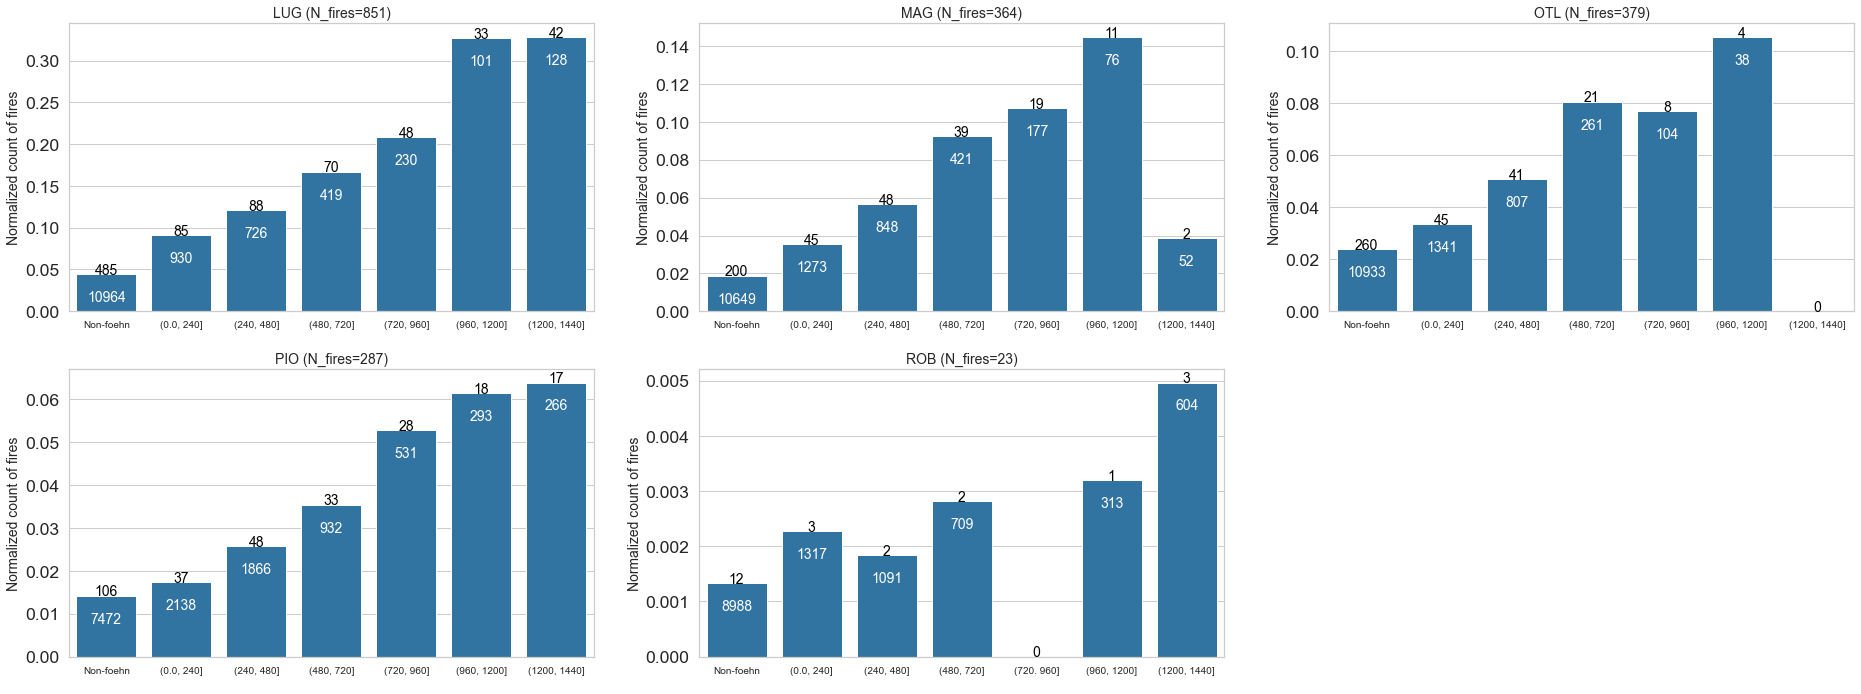

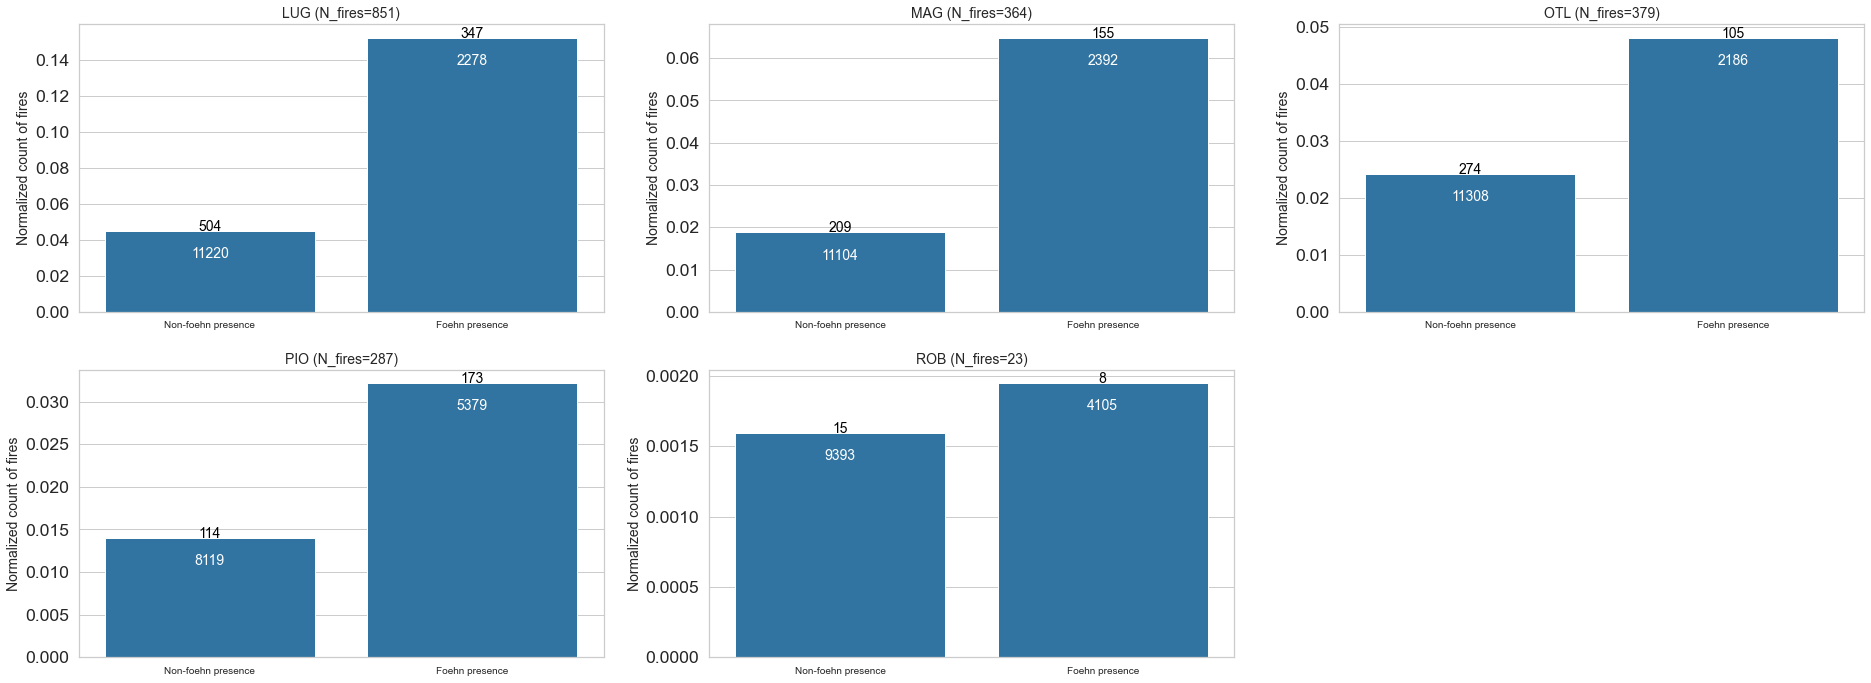

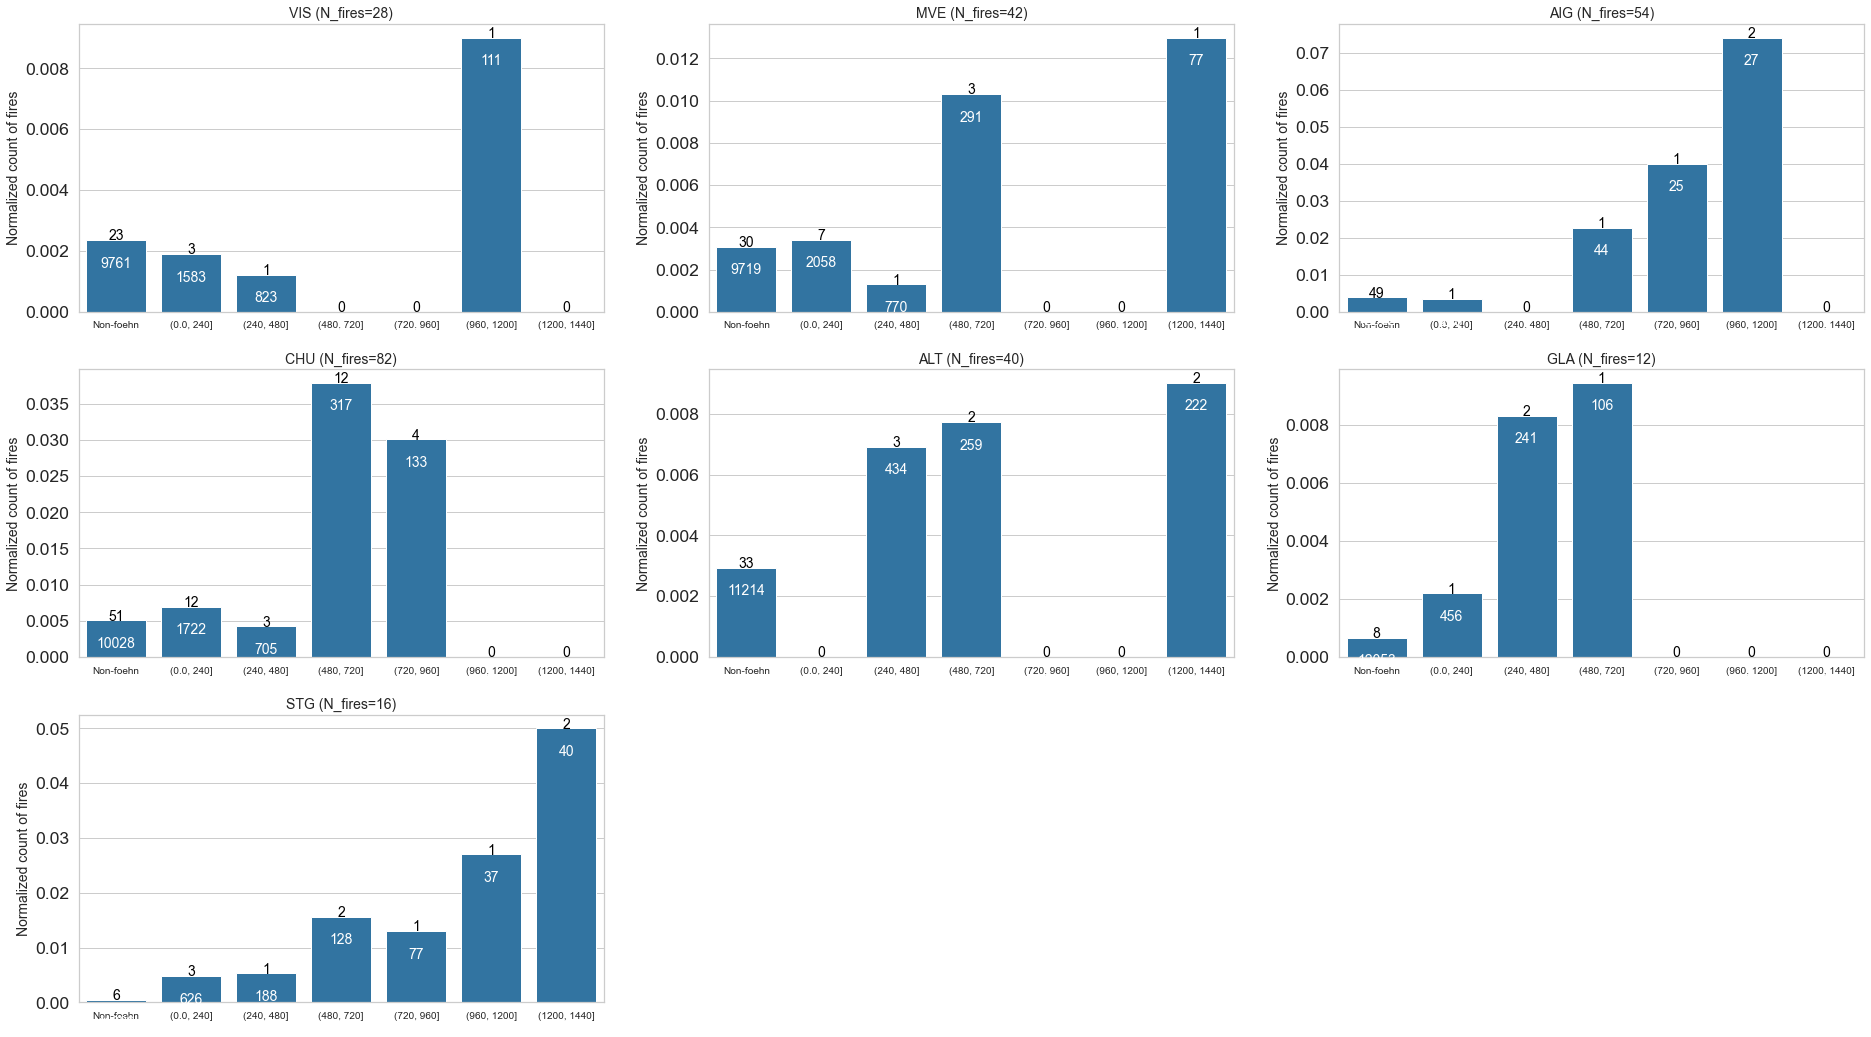

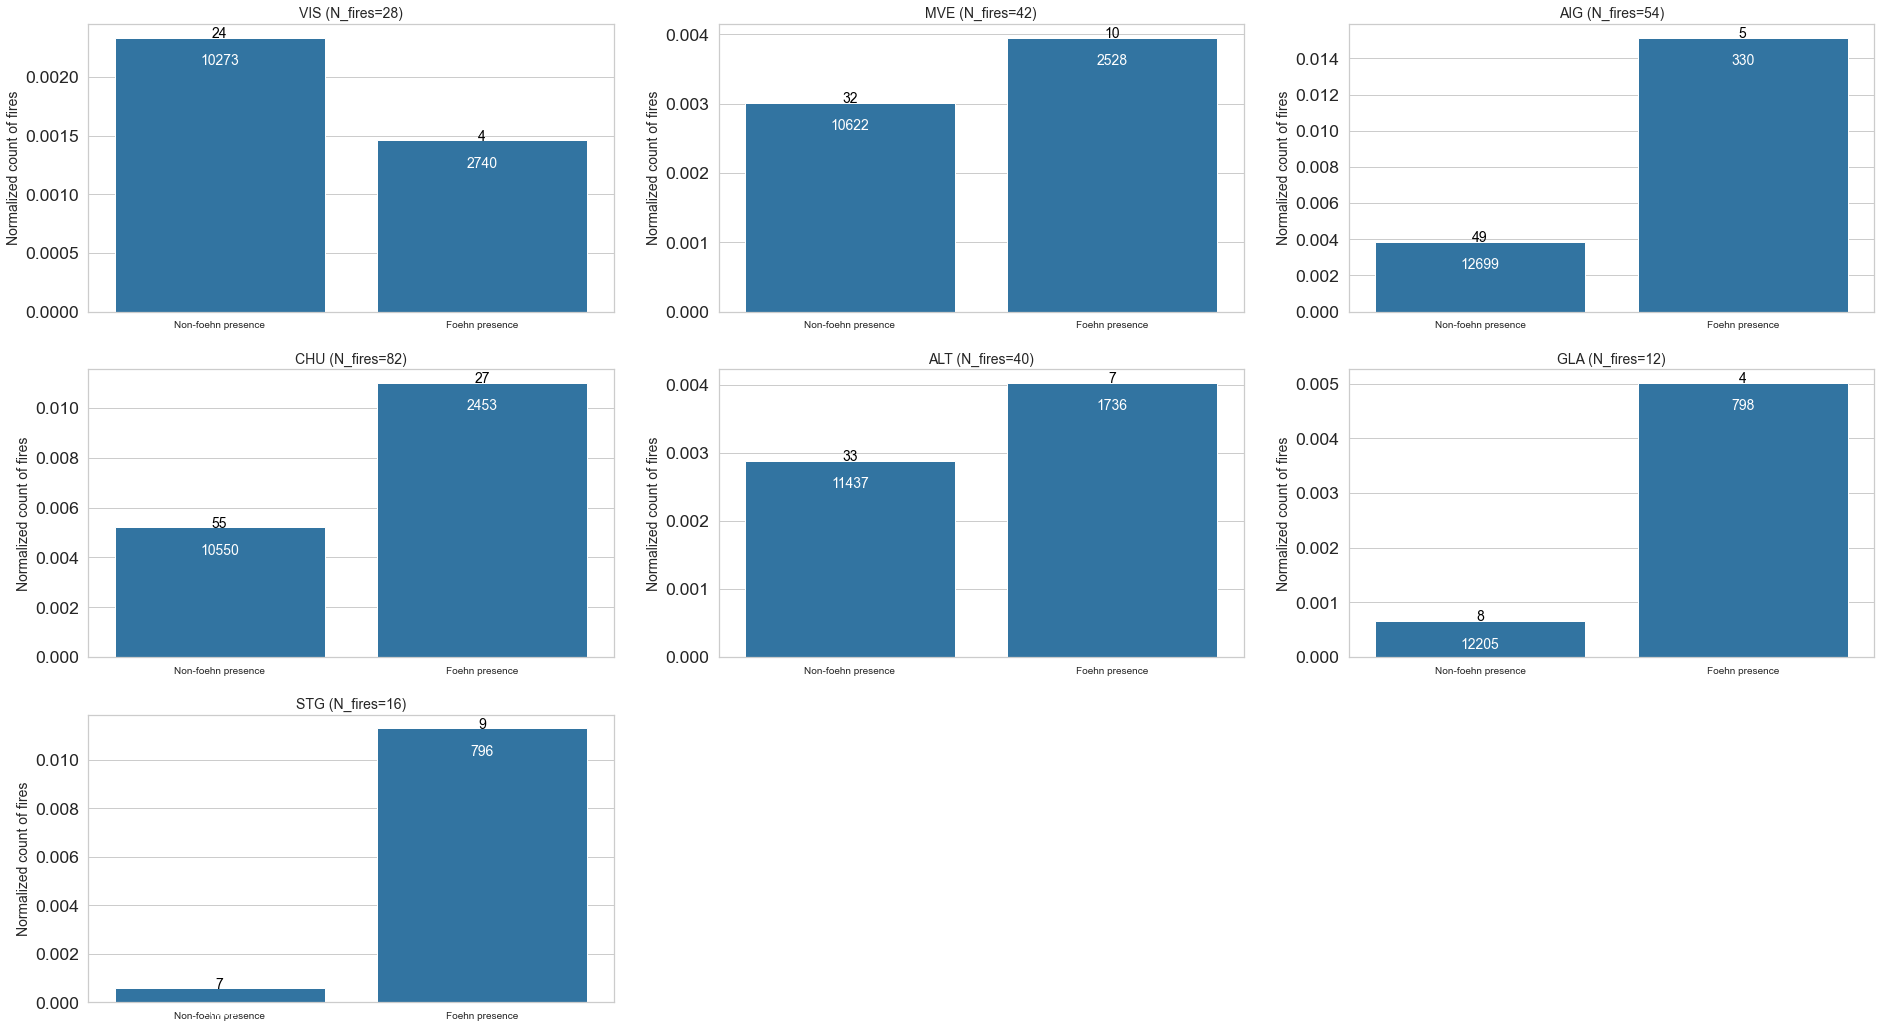

In [40]:
# Before fire start
for region in ["southern_switzerland", "northern_switzerland"]:
    print(region)
    plot_binned_fire_count_before_fire_start_single_station(df.loc[df["region"] == region, :], df_foehn=df_merge, hours=24, stations_in_region=regions[region])

## Temperature influence

In [ ]:
stations = [colname[0:3] for colname in df_foehn.filter(regex="foehn").columns]
north_foehn_stations = ["LUG", "OTL", "MAG", "COM", "GRO", "SBO", "PIO", "CEV", "ROB", "VIO"]
south_foehn_stations = set(stations) - set(north_foehn_stations)

for hour in [24,48]:
    plot_binned_fire_count_before_fire_start_temperature(df, df_foehn, hours=hour, stations=north_foehn_stations)